## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as settings
import pandas as pd
import yaml
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open ('trainfile_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Splits Data

In [3]:
df = pd.read_csv(config['training_file'])

In [4]:
#repleace the infinities with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

In [5]:
df.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,img_name,ThalamusDiameter,gestage,birthweight,BIIICss,BIIIRss,BIIIEss,Language Ability
0,0.0,20.0,77664,0.319064,13.0,3.900235,41,7.470333,6.447574,0,...,0.035045,0.017910,P0006_morph1_0000000D.png,1.837605,280.0,3520.0,normal,abnormal,abnormal,abnormal
1,0.0,25.0,135105,0.501164,13.0,4.136352,43,8.151758,8.079046,3,...,0.035075,0.017467,P0015_morph1_0000000A.png,1.886982,252.0,2750.0,normal,normal,normal,normal
2,1.0,31.0,198419,0.819558,15.0,5.318450,60,10.001134,13.720217,8,...,0.062125,0.017881,P0020_morph1_00000001.png,1.921918,280.0,3175.0,normal,normal,normal,normal
3,6.0,32.0,188462,1.014456,13.0,5.102134,65,8.834914,19.667606,17,...,0.111510,0.020570,P0020_morph1_00000002.png,1.700615,280.0,3175.0,normal,normal,normal,normal
4,12.0,67.0,937306,1.902161,31.0,6.080969,143,18.822240,36.614737,31,...,0.311790,0.013486,P0020_morph1_00000003.png,1.806750,280.0,3175.0,normal,normal,normal,normal


In [6]:
df[config['target']]=df[config['target']].map({'normal': 0, 'abnormal': 1})
df[config['target']].value_counts()


BIIIRss
0    157
1    107
Name: count, dtype: int64

In [7]:
columns_to_drop = ['img_name', 'ThalamusDiameter', 'gestage', 'birthweight', 'Language Ability']
columns_to_drop = [col for col in columns_to_drop]
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
df = df[df[config['target']].notna()]

To deal with imbalanced data

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
columns_to_drop = ['BIIICss', 'BIIIRss', 'BIIIEss']
columns_to_drop = [col for col in columns_to_drop]

X = df.drop(columns_to_drop, axis=1)
y = df[config['target']]
print(f'The target is {config["target"]}')

The target is BIIIRss


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
sm = SMOTE(random_state=42,k_neighbors=3)
# sampling_strategy=2 means that we want to have twice as many positive instances as negative instances
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Checking the new class distribution
print(f'Before SMOTE: {sum(y_train == 1)} positive instances and {sum(y_train == 0)} negative instances.')
print(f'After SMOTE: {sum(y_train_res == 1)} positive instances and {sum(y_train_res == 0)} negative instances.')


Before SMOTE: 82 positive instances and 129 negative instances.
After SMOTE: 129 positive instances and 129 negative instances.


In [13]:
X_train = X_train_res
y_train = y_train_res

In [14]:
# Scale the data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegressionCV

In [16]:
lr_model = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 10),
    cv=10, #change this to larger number
    penalty='elasticnet',
    scoring='average_precision',
    solver='saga',
    max_iter=1000,
    random_state=101,
    l1_ratios=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
)

In [17]:
lr_model.fit(scaled_X_train,y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                     cv=10,
                     l1_ratios=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                1],
                     max_iter=1000, penalty='elasticnet', random_state=101,
                     scoring='average_precision', solver='saga')

In [18]:
print('Best C:', lr_model.C_)
print('Best L1 Ratio:', lr_model.l1_ratio_)

Best C: [166.81005372]
Best L1 Ratio: [0.7]


In [19]:
# Predcit using the model with the best C and L1 ratio
lr_pred = lr_model.predict(scaled_X_test)

Model performance

In [20]:
def evaluate_model(model, scaled_X_test, y_test):
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_auc_score
    y_pred = model.predict(scaled_X_test);
    y_positive_prob = model.predict_proba(scaled_X_test)[:,1]; # Probability of positive class (label 1)
    
    #get confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
    
    #get classification report
    report = pd.DataFrame((classification_report(y_test, y_pred,output_dict=True))).transpose()
    print('\nClassification Report:\n', report)
    
    #calculate AUC
    auc_score = roc_auc_score(y_test, y_positive_prob)
    print(f"\nAUC socre is: {auc_score}\n")
    return y_pred,report,auc_score

In [21]:
def save_results(name,model,scaled_X_test,y_test,target = config['target'], feature_selection = config['feature_selection_method']):
    """ Save accuracy, precision,recall, f1 and auc to the model_scores list
    """
    from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score,precision_score
    y_pred = model.predict(scaled_X_test)
    y_prob = model.predict_proba(scaled_X_test)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    
    results = {
        'Target': target,
        'Feature Selection': feature_selection,
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }
    model_scores.append(results)



Classification Report:
               precision    recall  f1-score    support
0              0.515152  0.607143  0.557377  28.000000
1              0.450000  0.360000  0.400000  25.000000
accuracy       0.490566  0.490566  0.490566   0.490566
macro avg      0.482576  0.483571  0.478689  53.000000
weighted avg   0.484420  0.490566  0.483143  53.000000

AUC socre is: 0.5157142857142858



(array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1]),
               precision    recall  f1-score    support
 0              0.515152  0.607143  0.557377  28.000000
 1              0.450000  0.360000  0.400000  25.000000
 accuracy       0.490566  0.490566  0.490566   0.490566
 macro avg      0.482576  0.483571  0.478689  53.000000
 weighted avg   0.484420  0.490566  0.483143  53.000000,
 0.5157142857142858)

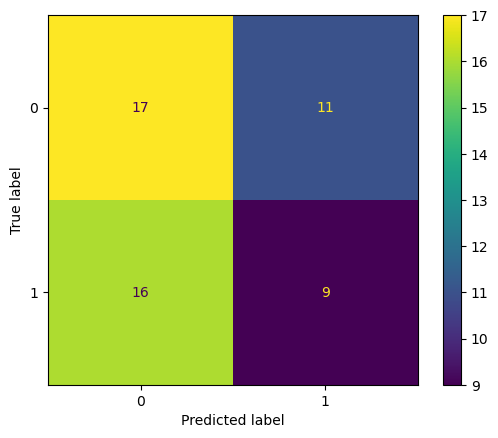

In [22]:
evaluate_model(lr_model, scaled_X_test, y_test)

In [23]:
from sklearn.metrics import RocCurveDisplay

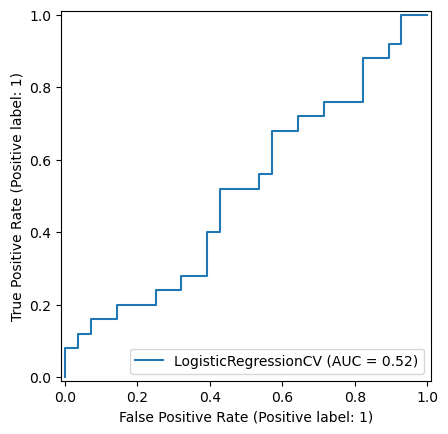

In [24]:
RocCurveDisplay.from_estimator(lr_model, scaled_X_test, y_test)

## K_Nearest_Neighbors

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [26]:
knn_model = KNeighborsClassifier()

In [27]:
knn_model.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [28]:
k_values = list(range(1,20))
param_grid = {'n_neighbors': k_values}

In [29]:
knnCV_model = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=10, scoring='average_precision')

In [30]:
knnCV_model.fit(scaled_X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             scoring='average_precision')

In [31]:
knnCV_model.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [32]:
#knnCV_model.cv_results_

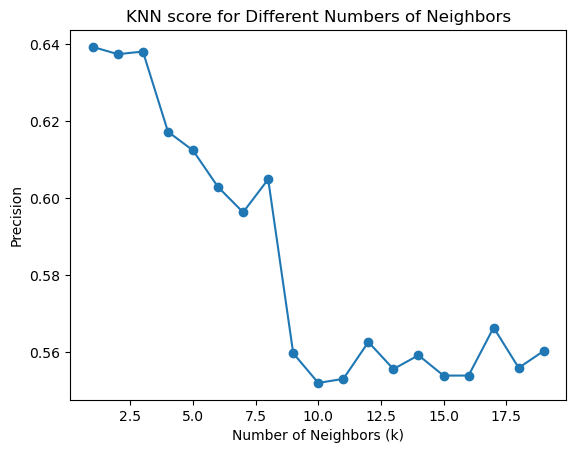

In [33]:
#plotting
mean_scores = knnCV_model.cv_results_['mean_test_score']

# Extract n_neighbors values
n_neighbors = param_grid['n_neighbors']

# Plotting
plt.plot(n_neighbors, mean_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Precision')
plt.title('KNN score for Different Numbers of Neighbors')
plt.show()

Evaluate KNN model


Classification Report:
               precision    recall  f1-score    support
0              0.642857  0.642857  0.642857  28.000000
1              0.600000  0.600000  0.600000  25.000000
accuracy       0.622642  0.622642  0.622642   0.622642
macro avg      0.621429  0.621429  0.621429  53.000000
weighted avg   0.622642  0.622642  0.622642  53.000000

AUC socre is: 0.6214285714285713



(array([1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1]),
               precision    recall  f1-score    support
 0              0.642857  0.642857  0.642857  28.000000
 1              0.600000  0.600000  0.600000  25.000000
 accuracy       0.622642  0.622642  0.622642   0.622642
 macro avg      0.621429  0.621429  0.621429  53.000000
 weighted avg   0.622642  0.622642  0.622642  53.000000,
 0.6214285714285713)

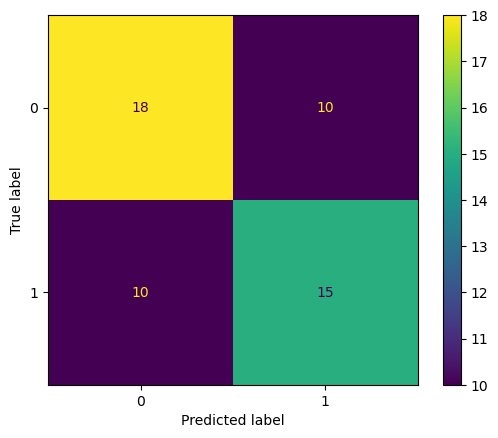

In [34]:
evaluate_model(knnCV_model, scaled_X_test, y_test)

## Suport Vector Machine

In [35]:
from sklearn.svm import SVC

In [36]:
svm_model = SVC()

In [37]:
svm_model.get_params()
param_grid_SVM = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'probability':[True, False]}

In [38]:
svm_modelCV = GridSearchCV(estimator=svm_model, param_grid=param_grid_SVM,scoring='average_precision',cv=10)
svm_modelCV.fit(scaled_X_train, y_train)
svm_modelCV.best_estimator_.get_params()


{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [39]:
print(svm_modelCV.best_params_)

{'kernel': 'linear', 'probability': True}



Classification Report:
               precision    recall  f1-score   support
0              0.483871  0.535714  0.508475  28.00000
1              0.409091  0.360000  0.382979  25.00000
accuracy       0.452830  0.452830  0.452830   0.45283
macro avg      0.446481  0.447857  0.445727  53.00000
weighted avg   0.448597  0.452830  0.449278  53.00000

AUC socre is: 0.4828571428571429



(array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1]),
               precision    recall  f1-score   support
 0              0.483871  0.535714  0.508475  28.00000
 1              0.409091  0.360000  0.382979  25.00000
 accuracy       0.452830  0.452830  0.452830   0.45283
 macro avg      0.446481  0.447857  0.445727  53.00000
 weighted avg   0.448597  0.452830  0.449278  53.00000,
 0.4828571428571429)

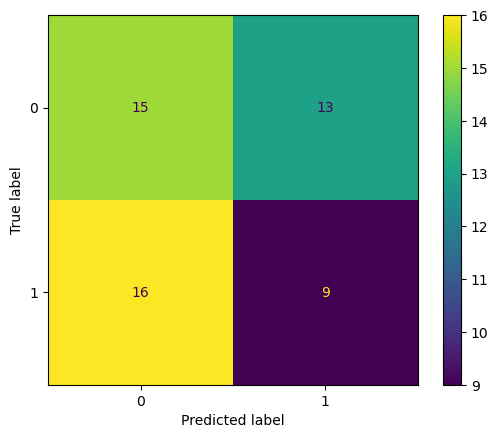

In [40]:
evaluate_model(svm_modelCV, scaled_X_test, y_test)

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
#Change this is the dataset is too large
n_estimators = list(range(1,64,2))
bootstrap = [True, False]
oob_score = [True, False]

param_grid_RF = {'n_estimators': n_estimators,  
                 'bootstrap': bootstrap,
                 'oob_score': oob_score}


In [43]:
rf_model = RandomForestClassifier(random_state=101)

In [44]:
rf_modelCV = GridSearchCV(estimator=rf_model, param_grid=param_grid_RF, cv=10, scoring= 'average_precision')

In [45]:
rf_modelCV.fit(scaled_X_train, y_train)
rf_modelCV.best_params_

{'bootstrap': False, 'n_estimators': 63, 'oob_score': False}

In [46]:
len(n_estimators)

32

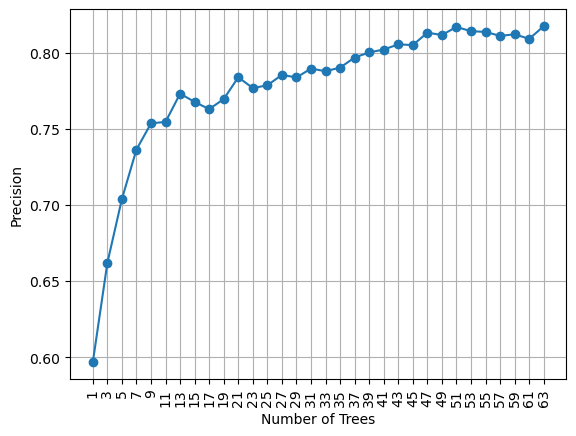

In [47]:
cv_results_df = pd.DataFrame(rf_modelCV.cv_results_)
filtered_results = cv_results_df[(cv_results_df['param_bootstrap'] == False) & (cv_results_df['param_oob_score'] == False)]
plt.plot(filtered_results['param_n_estimators'], filtered_results['mean_test_score'], marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Precision')
plt.xticks(n_estimators, rotation=90)

plt.grid(True)

In [48]:
# Build a model with the best parameters, see the feature importance
rf_best = RandomForestClassifier(n_estimators=13, oob_score=False, bootstrap=False, random_state=101)
rf_best.fit(scaled_X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=13, random_state=101)

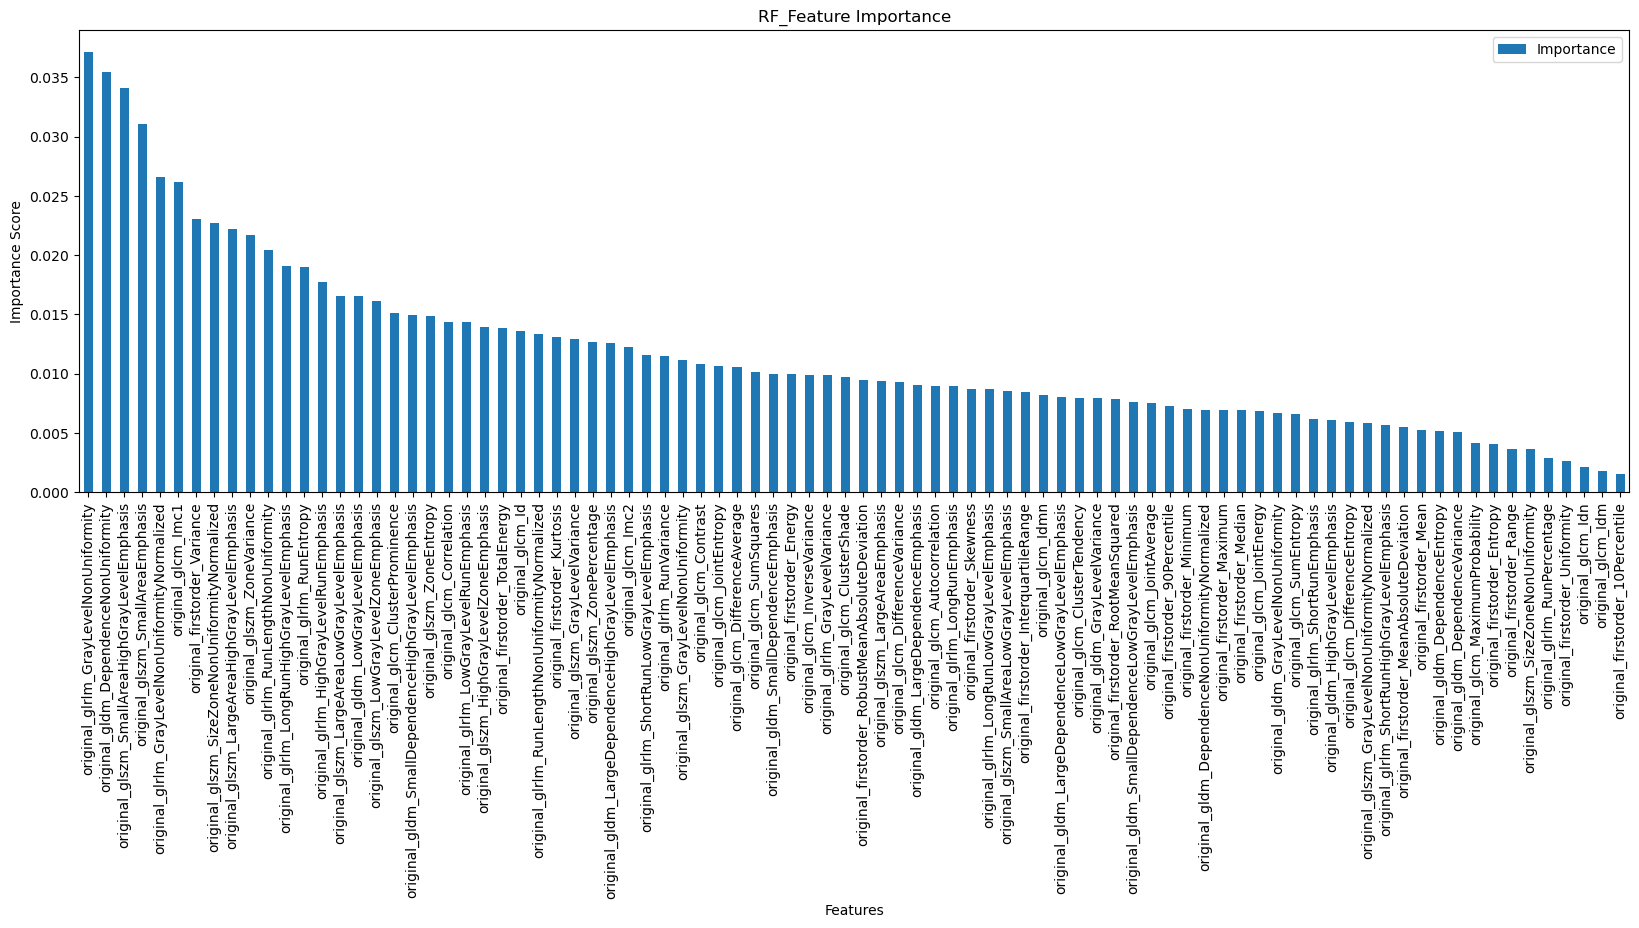

In [49]:
RF_featuredf = pd.DataFrame(rf_best.feature_importances_, index=X.columns, columns=['Importance'])
RF_featuredf = RF_featuredf.sort_values(by='Importance', ascending=False)
RF_featuredf.plot(kind='bar',
                  figsize=(20, 6),
                  title = 'RF_Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


Classification Report:
               precision    recall  f1-score    support
0              0.593750  0.678571  0.633333  28.000000
1              0.571429  0.480000  0.521739  25.000000
accuracy       0.584906  0.584906  0.584906   0.584906
macro avg      0.582589  0.579286  0.577536  53.000000
weighted avg   0.583221  0.584906  0.580695  53.000000

AUC socre is: 0.59



(array([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 1]),
               precision    recall  f1-score    support
 0              0.593750  0.678571  0.633333  28.000000
 1              0.571429  0.480000  0.521739  25.000000
 accuracy       0.584906  0.584906  0.584906   0.584906
 macro avg      0.582589  0.579286  0.577536  53.000000
 weighted avg   0.583221  0.584906  0.580695  53.000000,
 0.59)

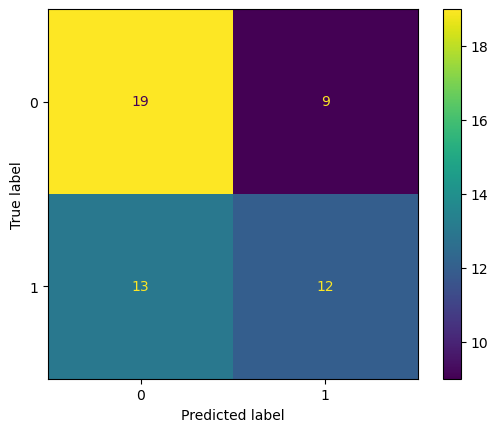

In [50]:
evaluate_model(rf_best, scaled_X_test, y_test)

## AdaBoost

In [51]:
from sklearn.ensemble import AdaBoostClassifier

In [52]:
adaboost_model = AdaBoostClassifier(random_state=101)
adaboost_model.fit(scaled_X_train, y_train)

AdaBoostClassifier(random_state=101)


Classification Report:
               precision    recall  f1-score    support
0              0.538462  0.500000  0.518519  28.000000
1              0.481481  0.520000  0.500000  25.000000
accuracy       0.509434  0.509434  0.509434   0.509434
macro avg      0.509972  0.510000  0.509259  53.000000
weighted avg   0.511584  0.509434  0.509783  53.000000

AUC socre is: 0.5714285714285715



(array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1]),
               precision    recall  f1-score    support
 0              0.538462  0.500000  0.518519  28.000000
 1              0.481481  0.520000  0.500000  25.000000
 accuracy       0.509434  0.509434  0.509434   0.509434
 macro avg      0.509972  0.510000  0.509259  53.000000
 weighted avg   0.511584  0.509434  0.509783  53.000000,
 0.5714285714285715)

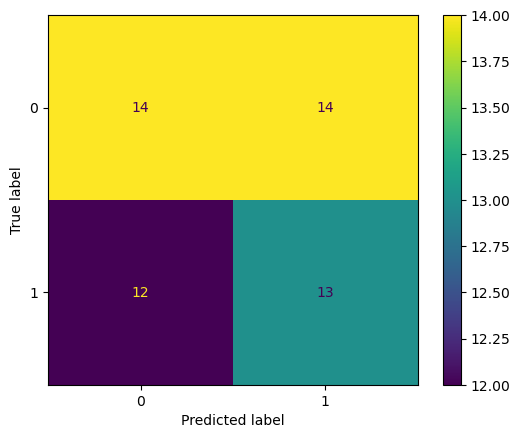

In [53]:
evaluate_model(adaboost_model, scaled_X_test, y_test)

## Gradient Boost

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
param_grid_GB = {'n_estimators':[1,5,10,20,40,60,80,100],
                 'max_depth':[3,4,5,6,7,8,9,10]}

gb_model = GradientBoostingClassifier(random_state=101)
gb_modelCV = GridSearchCV(estimator=gb_model, param_grid=param_grid_GB, cv=10, scoring='average_precision')

In [56]:
gb_modelCV.fit(scaled_X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=101),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [1, 5, 10, 20, 40, 60, 80, 100]},
             scoring='average_precision')

In [57]:
gb_modelCV.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [58]:
gb_model_test = GradientBoostingClassifier(n_estimators=100,max_depth=6,random_state=101)
gb_model_test.fit(scaled_X_train, y_train)


GradientBoostingClassifier(max_depth=6, random_state=101)


Classification Report:
               precision    recall  f1-score    support
0              0.586207  0.607143  0.596491  28.000000
1              0.541667  0.520000  0.530612  25.000000
accuracy       0.566038  0.566038  0.566038   0.566038
macro avg      0.563937  0.563571  0.563552  53.000000
weighted avg   0.565197  0.566038  0.565416  53.000000

AUC socre is: 0.5671428571428571



(array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 1]),
               precision    recall  f1-score    support
 0              0.586207  0.607143  0.596491  28.000000
 1              0.541667  0.520000  0.530612  25.000000
 accuracy       0.566038  0.566038  0.566038   0.566038
 macro avg      0.563937  0.563571  0.563552  53.000000
 weighted avg   0.565197  0.566038  0.565416  53.000000,
 0.5671428571428571)

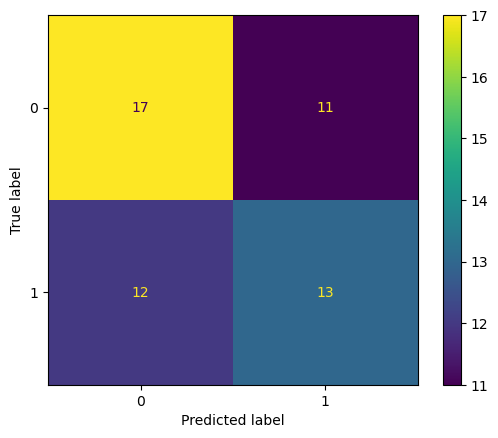

In [59]:
evaluate_model(gb_modelCV, scaled_X_test, y_test)

## Decision Tree

In [60]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
dt_model = DecisionTreeClassifier(random_state=101)
dt_model.fit(scaled_X_train, y_train)

DecisionTreeClassifier(random_state=101)


Classification Report:
               precision    recall  f1-score    support
0              0.575758  0.678571  0.622951  28.000000
1              0.550000  0.440000  0.488889  25.000000
accuracy       0.566038  0.566038  0.566038   0.566038
macro avg      0.562879  0.559286  0.555920  53.000000
weighted avg   0.563608  0.566038  0.559714  53.000000

AUC socre is: 0.5592857142857143



(array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 1]),
               precision    recall  f1-score    support
 0              0.575758  0.678571  0.622951  28.000000
 1              0.550000  0.440000  0.488889  25.000000
 accuracy       0.566038  0.566038  0.566038   0.566038
 macro avg      0.562879  0.559286  0.555920  53.000000
 weighted avg   0.563608  0.566038  0.559714  53.000000,
 0.5592857142857143)

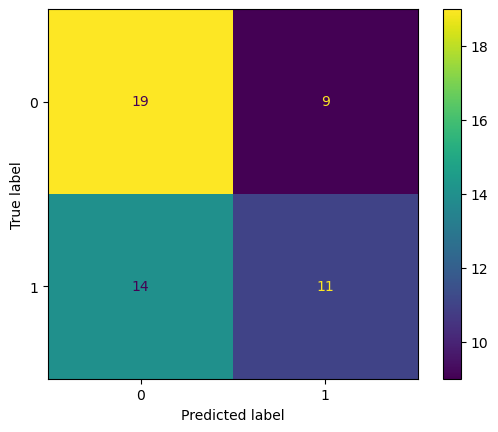

In [62]:
evaluate_model(dt_model, scaled_X_test, y_test)

## XGboost

In [63]:
import xgboost as xgb

In [64]:
xgb_model = xgb.XGBClassifier( eval_metric='logloss', random_state=101)
xgb_model.fit(scaled_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=101, ...)


Classification Report:
               precision    recall  f1-score    support
0              0.500000  0.571429  0.533333  28.000000
1              0.428571  0.360000  0.391304  25.000000
accuracy       0.471698  0.471698  0.471698   0.471698
macro avg      0.464286  0.465714  0.462319  53.000000
weighted avg   0.466307  0.471698  0.466339  53.000000

AUC socre is: 0.53



(array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 0]),
               precision    recall  f1-score    support
 0              0.500000  0.571429  0.533333  28.000000
 1              0.428571  0.360000  0.391304  25.000000
 accuracy       0.471698  0.471698  0.471698   0.471698
 macro avg      0.464286  0.465714  0.462319  53.000000
 weighted avg   0.466307  0.471698  0.466339  53.000000,
 0.53)

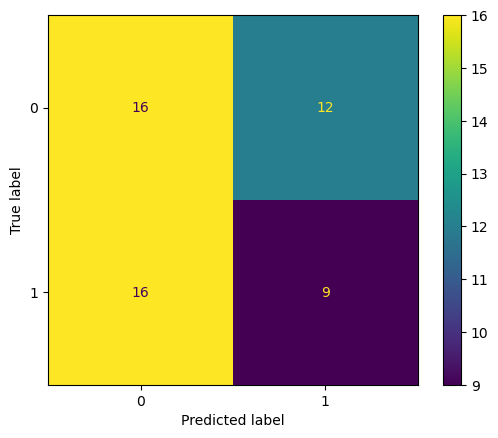

In [65]:
evaluate_model(xgb_model, scaled_X_test, y_test)

## Save the results to a excel file

In [66]:
model_scores = []
save_results('Logistic Regression',lr_model,scaled_X_test,y_test)
save_results('KNN',knnCV_model,scaled_X_test,y_test)
save_results('SVM',svm_modelCV,scaled_X_test,y_test)
save_results('Random Forest',rf_best,scaled_X_test,y_test)
save_results('AdaBoost',adaboost_model,scaled_X_test,y_test)
save_results('Gradient Boosting',gb_modelCV,scaled_X_test,y_test)
save_results('Decision Tree',dt_model,scaled_X_test,y_test)
save_results('XGBoost',xgb_model,scaled_X_test,y_test)



In [67]:
import os

In [68]:
results_df = pd.DataFrame(model_scores)

results_df.to_excel(os.path.join(config['output_dir']+'_'+config['target']+'.xlsx'), index=False)

# AutoGluon

In [69]:
# !pip install \
#    --no-binary lightgbm \
#    --config-settings=cmake.define.USE_OPENMP=OFF \
#    'lightgbm>=4.0.0'

In [70]:
#!python -m pip install autogluon

In [71]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [72]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [73]:
label =config['target']
predictor = TabularPredictor(label=label).fit(train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20240505_164921"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240505_164921"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 

In [74]:
y_pred = predictor.predict(test_df)

In [75]:
predictor.evaluate(test_df)

{'accuracy': 0.6226415094339622,
 'balanced_accuracy': 0.6192857142857143,
 'mcc': 0.24029398833128837,
 'roc_auc': 0.6557142857142856,
 'f1': 0.5833333333333334,
 'precision': 0.6086956521739131,
 'recall': 0.56}

In [76]:
autogluon_result = predictor.leaderboard(test_df, extra_metrics=['precision','recall','f1','roc_auc'])

In [77]:
autogluon_result = autogluon_result.iloc[:,0:9]
autogluon_result

,model,score_test,precision,recall,f1,roc_auc,score_val,eval_metric,pred_time_test
0,RandomForestEntr,0.641509,0.625000,0.60,0.612245,0.647143,0.500000,accuracy,0.032721
1,LightGBMLarge,0.622642,0.608696,0.56,0.583333,0.655714,0.692308,accuracy,0.001696
2,WeightedEnsemble_L2,0.622642,0.608696,0.56,0.583333,0.655714,0.692308,accuracy,0.002232
3,XGBoost,0.622642,0.619048,0.52,0.565217,0.642857,0.634615,accuracy,0.013566
4,RandomForestGini,0.622642,0.608696,0.56,0.583333,0.657143,0.557692,accuracy,0.030023
5,NeuralNetFastAI,0.603774,0.571429,0.64,0.603774,0.600000,0.653846,accuracy,0.015317
6,ExtraTreesGini,0.603774,0.590909,0.52,0.553191,0.587857,0.557692,accuracy,0.034326
7,KNeighborsDist,0.584906,0.571429,0.48,0.521739,0.594286,0.576923,accuracy,0.025056
8,ExtraTreesEntr,0.584906,0.571429,0.48,0.521739,0.572857,0.519231,accuracy,0.042165
9,NeuralNetTorch,0.547170,1.000000,0.04,0.076923,0.404286,0.557692,accuracy,0.007939


In [78]:
#save AutoGluon results to excel
autogluon_result.to_excel(os.path.join(config['output_dir']+'_'+config['target']+'AutoG'+'.xlsx'), index=False)

In [79]:
import seaborn as sns

In [80]:
predictor.get_model_best()

'WeightedEnsemble_L2'

These features in provided data are not utilized by the predictor and will be ignored: ['original_firstorder_TotalEnergy']
Computing feature importance via permutation shuffling for 85 features using 258 rows with 5 shuffle sets...
	4.17s	= Expected runtime (0.83s per shuffle set)
	0.64s	= Actual runtime (Completed 5 of 5 shuffle sets)


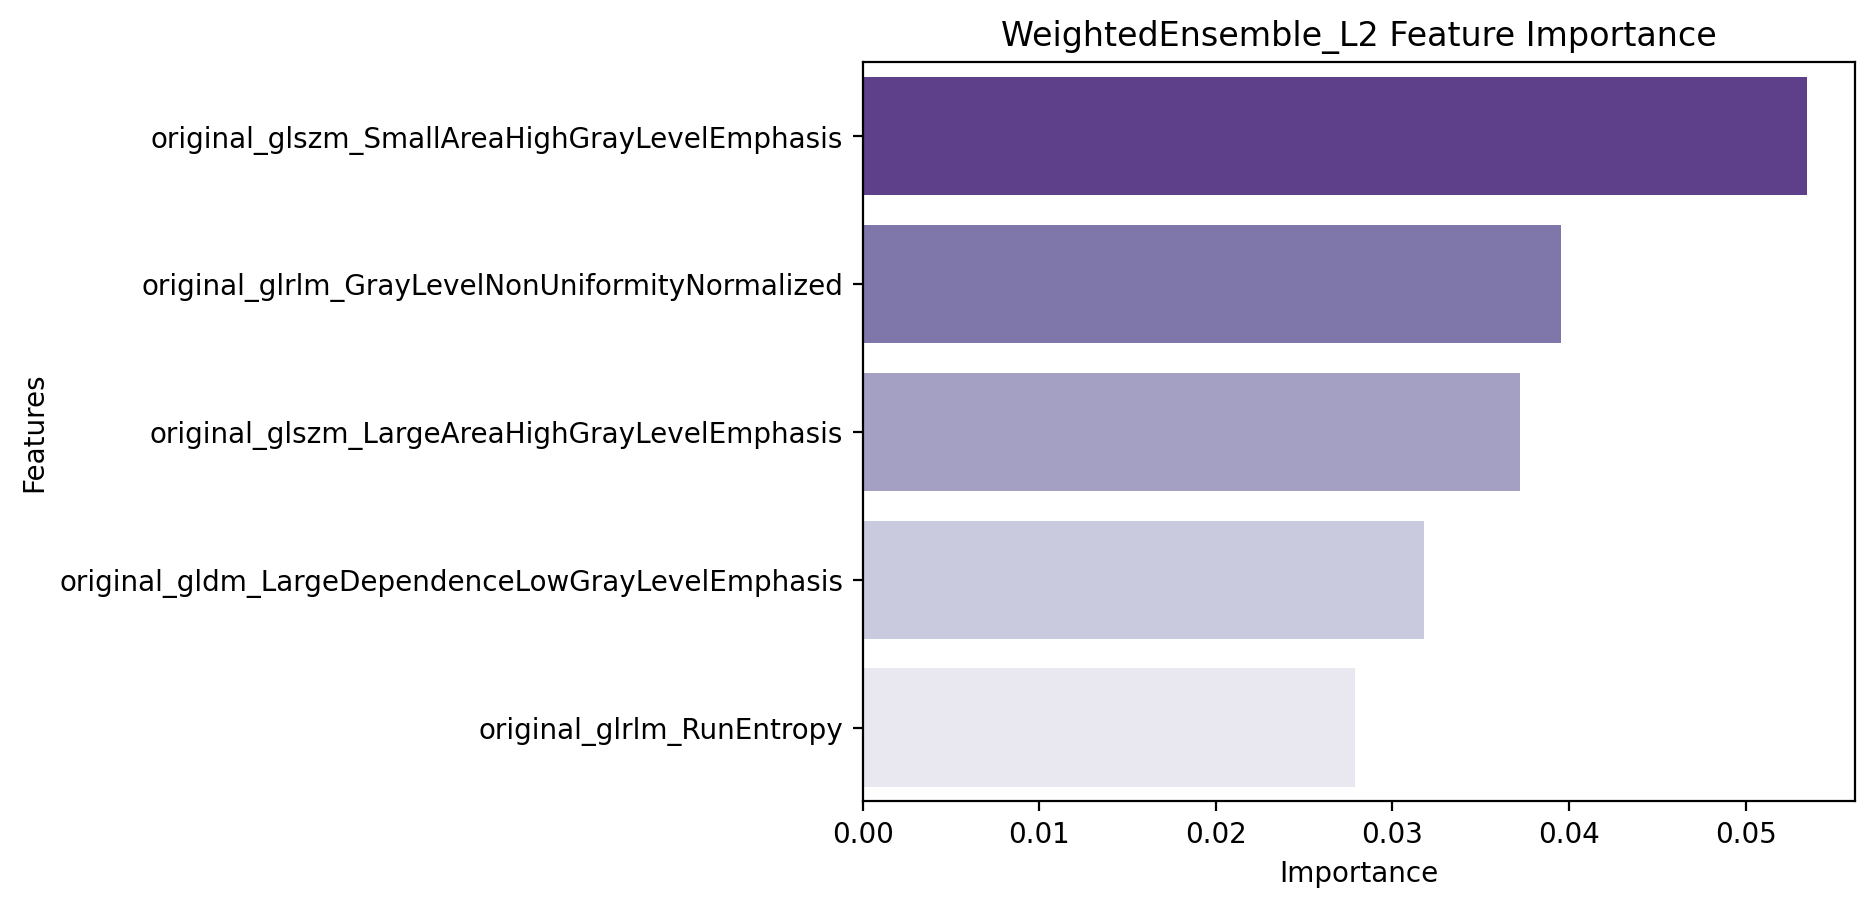

In [82]:
gluon_model = 'WeightedEnsemble_L2'
feature_importance = predictor.feature_importance(data=train_df, model=gluon_model)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance = feature_importance.nlargest(5,'importance')
plt.figure(dpi=200)
sns.barplot(x=feature_importance['importance'], y=feature_importance.index,palette='Purples_r')
plt.title(f'{gluon_model} Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

These features in provided data are not utilized by the predictor and will be ignored: ['original_firstorder_TotalEnergy']
Computing feature importance via permutation shuffling for 85 features using 258 rows with 5 shuffle sets...
	15.01s	= Expected runtime (3.0s per shuffle set)
	0.41s	= Actual runtime (Completed 5 of 5 shuffle sets)


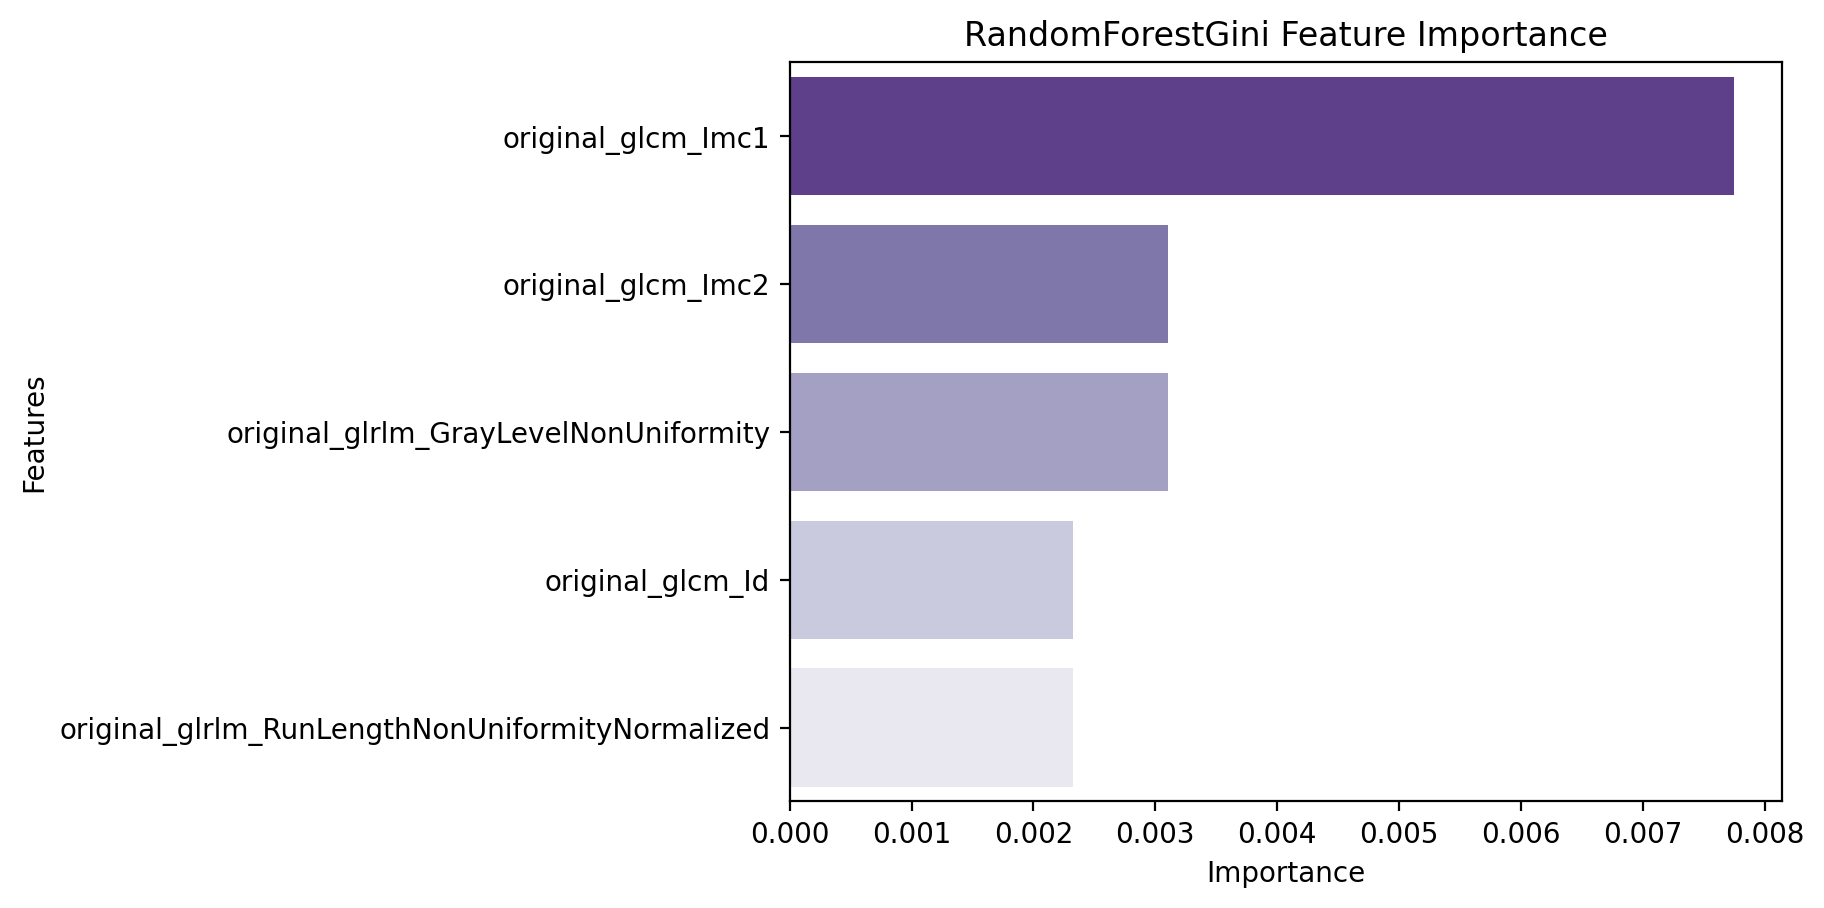

In [83]:
gluon_model = 'RandomForestGini'
feature_importance = predictor.feature_importance(data=train_df, model=gluon_model)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance = feature_importance.nlargest(5,'importance')
plt.figure(dpi=200)
sns.barplot(x=feature_importance['importance'], y=feature_importance.index,palette='Purples_r')
plt.title(f'{gluon_model} Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()